# Objective of the notebook
In this Notebook we focus on generating names using RNN based models. In the first part, we train a RNN based model to classify names as females and males.

In the second part, we train GRU Models to generate Male and female names. We then use the classifier to check how well the model performs with the classifier built earlier

We also build models to particularly generate names starting with M and Z and also check the perplexity of the model

#### Importing Libraries

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense

import matplotlib as plt
get_ipython().magic(u'matplotlib inline')

import datetime as dt, itertools, pandas as pd, matplotlib.pyplot as plt, numpy as np

In [ ]:
dataset_df=pd.read_csv('/content/sample_data/name_gender.csv')
dataset_df

,name,gender,probability
0,Aaban,M,1.0
1,Aabha,F,1.0
2,Aabid,M,1.0
3,Aabriella,F,1.0
4,Aada,F,1.0
...,...,...,...
95021,Zyvon,M,1.0
95022,Zyyanna,F,1.0
95023,Zyyon,M,1.0
95024,Zzyzx,M,1.0


#### EDA

In [ ]:
# Preprocess the data
dataset_df['name'] = dataset_df['name'].apply(lambda x: ''.join([i for i in x if ord(i) < 128]))  # Remove non-ascii characters
dataset_df['gender'] = dataset_df['gender'].map({'M': 0, 'F': 1})  # Convert labels to numerical values
dataset_df

,name,gender,probability
0,Aaban,0,1.0
1,Aabha,1,1.0
2,Aabid,0,1.0
3,Aabriella,1,1.0
4,Aada,1,1.0
...,...,...,...
95021,Zyvon,0,1.0
95022,Zyyanna,1,1.0
95023,Zyyon,0,1.0
95024,Zzyzx,0,1.0


In [ ]:
dataset_df['gender'].value_counts()

1    60304
0    34722
Name: gender, dtype: int64

In [ ]:
dataset_df.isna().sum()

name           0
gender         0
probability    1
dtype: int64

In [ ]:
dataset_df=dataset_df.dropna()
dataset_df

,name,gender,probability
0,Aaban,0,1.0
1,Aabha,1,1.0
2,Aabid,0,1.0
3,Aabriella,1,1.0
4,Aada,1,1.0
...,...,...,...
95020,Zyvion,0,1.0
95021,Zyvon,0,1.0
95022,Zyyanna,1,1.0
95023,Zyyon,0,1.0


### 1) Building a text classifier using RNN, LSTM and GRU


##### Preprocessing

In [ ]:
dataset_df.isna().sum()

name           0
gender         0
probability    0
dtype: int64

In [ ]:
# One-hot encode the characters
all_chars = set(''.join(dataset_df['name']))
char_index = {char: idx for idx, char in enumerate(all_chars)}
max_len = max(len(name) for name in dataset_df['name'])


In [ ]:
all_chars

{'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [ ]:
max_len

15

In [ ]:
X = np.zeros((len(dataset_df), max_len, len(all_chars)), dtype=np.uint8)
for i, name in enumerate(dataset_df['name']):
    for j, char in enumerate(name):
        X[i, j, char_index[char]] = 1
X.shape

(95025, 15, 52)

In [ ]:
X

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

#### Fitting a RNN, LSTM and GRU for text classification

In [ ]:
y = dataset_df['gender'].values

# Function to build and train the model
def build_and_train_model(rnn_cell, X_train, y_train, X_test, y_test,model):
    model = Sequential()
    model.add(rnn_cell(128, input_shape=(max_len, len(all_chars))))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=0)

    return model


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Experiment with different RNN cells and dataset sizes
rnn_cells = [SimpleRNN, LSTM, GRU]
dataset_sizes = [0.25, 0.5, 0.75, 0.99]

In [ ]:
SimpleRNN_model = Sequential()
LSTM_model = Sequential()
GRU_model = Sequential()
rnn_models = [SimpleRNN_model, LSTM_model, GRU_model]
for rnn_cell,rnn_model in zip(rnn_cells,rnn_models):
    print(f"\nTesting {rnn_cell.__name__} cell:")
    for size in dataset_sizes:
        X_partial, _, y_partial, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
        rnn_model = build_and_train_model(rnn_cell, X_partial, y_partial, X_test, y_test,rnn_model)
        _, accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)
        print(f"Dataset size: {size * 100}%  Accuracy: {accuracy * 100:.2f}%")


Testing SimpleRNN cell:
Dataset size: 25.0%  Accuracy: 81.98%
Dataset size: 50.0%  Accuracy: 84.38%
Dataset size: 75.0%  Accuracy: 85.51%
Dataset size: 99.0%  Accuracy: 86.22%

Testing LSTM cell:
Dataset size: 25.0%  Accuracy: 81.95%
Dataset size: 50.0%  Accuracy: 85.03%
Dataset size: 75.0%  Accuracy: 85.59%
Dataset size: 99.0%  Accuracy: 86.81%

Testing GRU cell:
Dataset size: 25.0%  Accuracy: 83.43%
Dataset size: 50.0%  Accuracy: 85.41%
Dataset size: 75.0%  Accuracy: 85.79%
Dataset size: 99.0%  Accuracy: 86.96%


We see GRU's performing the best. Let's train the model on GRU's

In [ ]:
# Build the model with GRU
GRU_model = Sequential()
GRU_model.add(GRU(156, input_shape=(max_len, len(all_chars))))
GRU_model.add(Dense(1, activation='sigmoid'))

# Compile the model
GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
GRU_model.fit(X_train, y_train, epochs=50, batch_size=512)

Epoch 1/50
149/149 [==============================] - 4s 7ms/step - loss: 0.5204 - accuracy: 0.7412
Epoch 2/50
149/149 [==============================] - 1s 6ms/step - loss: 0.4436 - accuracy: 0.7962
Epoch 3/50
149/149 [==============================] - 1s 6ms/step - loss: 0.3838 - accuracy: 0.8290
Epoch 4/50
149/149 [==============================] - 1s 6ms/step - loss: 0.3568 - accuracy: 0.8432
Epoch 5/50
149/149 [==============================] - 1s 6ms/step - loss: 0.3436 - accuracy: 0.8515
Epoch 6/50
149/149 [==============================] - 1s 7ms/step - loss: 0.3319 - accuracy: 0.8564
Epoch 7/50
149/149 [==============================] - 1s 7ms/step - loss: 0.3248 - accuracy: 0.8594
Epoch 8/50
149/149 [==============================] - 1s 7ms/step - loss: 0.3165 - accuracy: 0.8643
Epoch 9/50
149/149 [==============================] - 1s 6ms/step - loss: 0.3098 - accuracy: 0.8670
Epoch 10/50
149/149 [==============================] - 1s 6ms/step - loss: 0.3008 - accuracy: 0.8707

In [ ]:
loss, accuracy = GRU_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

594/594 [==============================] - 3s 4ms/step - loss: 0.3227 - accuracy: 0.8987
Test Loss: 0.3227, Test Accuracy: 0.8987


594/594 [==============================] - 2s 3ms/step


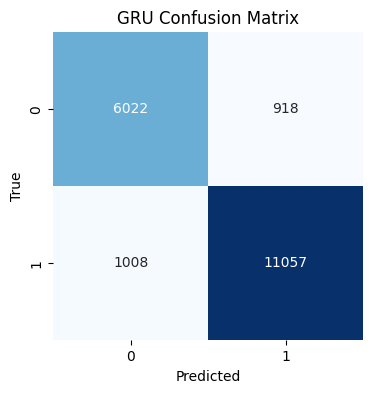

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


gru_predictions = GRU_model.predict(X_test)
gru_predictions = (gru_predictions >= 0.5).astype(int)
gru_predictions=gru_predictions.reshape(-1)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# Plot confusion matrix for GRU model
plot_confusion_matrix(y_test, gru_predictions, 'GRU Confusion Matrix')



We see the model decently classfies names at 90% accuracy

## Problem 2: Train a GRU model with all the names to generate 100 male and female names

In [ ]:
dataset_df

,name,gender,probability
0,Aaban,0,1.0
1,Aabha,1,1.0
2,Aabid,0,1.0
3,Aabriella,1,1.0
4,Aada,1,1.0
...,...,...,...
95020,Zyvion,0,1.0
95021,Zyvon,0,1.0
95022,Zyyanna,1,1.0
95023,Zyyon,0,1.0


In [ ]:
dataset_df=pd.read_csv('/content/sample_data/name_gender.csv')
dataset_df

,name,gender,probability
0,Aaban,M,1.0
1,Aabha,F,1.0
2,Aabid,M,1.0
3,Aabriella,F,1.0
4,Aada,F,1.0
...,...,...,...
95021,Zyvon,M,1.0
95022,Zyyanna,F,1.0
95023,Zyyon,M,1.0
95024,Zzyzx,M,1.0


In [ ]:
dataset_df['name'] = dataset_df['name'].apply(lambda x: ''.join([i for i in x if ord(i) < 128]))  # Remove non-ascii characters
dataset_df['gender'] = dataset_df['gender'].map({'M': 0, 'F': 1})  # Convert labels to numerical values
dataset_df['name'] = dataset_df['name'].apply(lambda x: ''.join([i for i in x if ord(i) < 128]))  # Remove non-ascii characters
dataset_df=dataset_df.dropna()

In [ ]:
dataset_df

,name,gender,probability
0,Aaban,0,1.0
1,Aabha,1,1.0
2,Aabid,0,1.0
3,Aabriella,1,1.0
4,Aada,1,1.0
...,...,...,...
95020,Zyvion,0,1.0
95021,Zyvon,0,1.0
95022,Zyyanna,1,1.0
95023,Zyyon,0,1.0


In [ ]:
female_dataset_df=dataset_df[dataset_df['gender'] ==1]
female_dataset_df

,name,gender,probability
1,Aabha,1,1.0
3,Aabriella,1,1.0
4,Aada,1,1.0
13,Aadhira,1,1.0
15,Aadhya,1,1.0
...,...,...,...
95002,Zyriel,1,1.0
95003,Zyrielle,1,1.0
95004,Zyrihanna,1,1.0
95007,Zyriyah,1,1.0


In [ ]:
male_dataset_df=dataset_df[dataset_df['gender'] ==0]
male_dataset_df

,name,gender,probability
0,Aaban,0,1.0
2,Aabid,0,1.0
5,Aadam,0,1.0
6,Aadan,0,1.0
7,Aadarsh,0,1.0
...,...,...,...
95019,Zyus,0,1.0
95020,Zyvion,0,1.0
95021,Zyvon,0,1.0
95023,Zyyon,0,1.0


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop


### Fitering Male names to train a language model to generate a Male Names

In [ ]:
name_list_male=male_dataset_df['name'].to_list()
name_list_male

['Aaban',
 'Aabid',
 'Aadam',
 'Aadan',
 'Aadarsh',
 'Aaden',
 'Aadesh',
 'Aadhav',
 'Aadhavan',
 'Aadhi',
 'Aadhvik',
 'Aadhyan',
 'Aadi',
 'Aadian',
 'Aadil',
 'Aadin',
 'Aadish',
 'Aadit',
 'Aadith',
 'Aadithya',
 'Aaditya',
 'Aadiv',
 'Aadon',
 'Aadrian',
 'Aadrit',
 'Aadvik',
 'Aadyn',
 'Aagam',
 'Aage',
 'Aahaan',
 'Aahan',
 'Aahil',
 'Aahir',
 'Aahron',
 'Aaidan',
 'Aaiden',
 'Aaidyn',
 'Aajon',
 'Aakarsh',
 'Aakash',
 'Aakeem',
 'Aalap',
 'Aali',
 'Aalias',
 'Aalijah',
 'Aalim',
 'Aalok',
 'Aalon',
 'Aamar',
 'Aamari',
 'Aamarion',
 'Aamer',
 'Aamil',
 'Aamir',
 'Aanand',
 'Aanav',
 'Aansh',
 'Aaqib',
 'Aaqil',
 'Aaradhy',
 'Aaraiz',
 'Aaran',
 'Aaraon',
 'Aarav',
 'Aaren',
 'Aareon',
 'Aarian',
 'Aarib',
 'Aaric',
 'Aarick',
 'Aarien',
 'Aarik',
 'Aariketh',
 'Aarin',
 'Aarion',
 'Aarish',
 'Aarit',
 'Aariv',
 'Aariyan',
 'Aariz',
 'Aarjav',
 'Aarn',
 'Aarnav',
 'Aarne',
 'Aaro',
 'Aaroh',
 'Aarohan',
 'Aaron',
 'Aaronjacob',
 'Aaronjames',
 'Aaronjohn',
 'Aaronjoseph',
 'Aaro

In [ ]:
step_length = 1    # The step length we take to get our samples from our corpus
epochs = 100       # Number of times we train on our full data
batch_size = 32    # Data samples in each training step
latent_dim = 64    # Size of our LSTM
dropout_rate = 0.2 # Regularization with dropout

load_model = False # Enable loading model from disk
store_model = True # Store model to disk after training
verbosity = 1      # Print result for each epoch
gen_amount = 7    # How many


### Pre-processing data

In [ ]:
concat_names = '\n'.join(name_list_male).lower()
# Find all unique characters by using set()
chars = sorted(list(set(concat_names)))
num_chars = len(chars)

# Build translation dictionaries, 'a' -> 0, 0 -> 'a'
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

# Use longest name length as our sequence window
max_sequence_length = max([len(name) for name in name_list_male])

print('Total chars: {}'.format(num_chars))
print('Corpus length:', len(concat_names))
print('Number of names: ', len(name_list_male))
print('Longest name: ', max_sequence_length)

Total chars: 27
Corpus length: 253107
Number of names:  34722
Longest name:  15


In [ ]:
char2idx,idx2char

({'\n': 0,
  'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26},
 {0: '\n',
  1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z'})

In [ ]:
sequences = []
next_chars = []

# Loop over our data and extract pairs of sequances and next chars
for i in range(0, len(concat_names) - max_sequence_length, step_length):
    sequences.append(concat_names[i: i + max_sequence_length])
    next_chars.append(concat_names[i + max_sequence_length])

num_sequences = len(sequences)

print('Number of sequences:', num_sequences)
print('First 10 sequences and next chars:')
for i in range(7):
    print('X=[{}]   y=[{}]'.replace('\n', ' ').format(sequences[i], next_chars[i]).replace('\n', ' '))

Number of sequences: 253092
First 10 sequences and next chars:
X=[aaban aabid aad]   y=[a]
X=[aban aabid aada]   y=[m]
X=[ban aabid aadam]   y=[ ]
X=[an aabid aadam ]   y=[a]
X=[n aabid aadam a]   y=[a]
X=[ aabid aadam aa]   y=[d]
X=[aabid aadam aad]   y=[a]


In [ ]:
X = np.zeros((num_sequences, max_sequence_length, num_chars), dtype=bool)
Y = np.zeros((num_sequences, num_chars), dtype=bool)

for i, sequence in enumerate(sequences):
    for j, char in enumerate(sequence):
        X[i, j, char2idx[char]] = 1
    Y[i, char2idx[next_chars[i]]] = 1

print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

X shape: (253092, 15, 27)
Y shape: (253092, 27)


In [ ]:
X

array([[[False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        ...,
        [False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False,  True, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        ...,
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False]],

       [[False, False,  True, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False,  True, False, ..., False, Fal

Building a language model with 2 layers to generate male names

In [ ]:
model_male = Sequential()
model_male.add(GRU(latent_dim,
               input_shape=(max_sequence_length, num_chars),
               recurrent_dropout=dropout_rate,return_sequences=True))
model_male.add(GRU(latent_dim, recurrent_dropout=dropout_rate))
model_male.add(Dense(units=num_chars, activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model_male.compile(loss='categorical_crossentropy',
              optimizer=optimizer)

model_male.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 15, 64)            17856     
                                                                 
 gru_9 (GRU)                 (None, 64)                24960     
                                                                 
 dense_5 (Dense)             (None, 27)                1755      
                                                                 
Total params: 44571 (174.11 KB)
Trainable params: 44571 (174.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_male.fit(X, Y, epochs=10, batch_size=1024, verbose=verbosity)

Epoch 1/10
248/248 [==============================] - 29s 99ms/step - loss: 2.0022
Epoch 2/10
248/248 [==============================] - 25s 100ms/step - loss: 1.2942
Epoch 3/10
248/248 [==============================] - 25s 99ms/step - loss: 1.1749
Epoch 4/10
248/248 [==============================] - 25s 99ms/step - loss: 1.1225
Epoch 5/10
248/248 [==============================] - 25s 100ms/step - loss: 1.0864
Epoch 6/10
248/248 [==============================] - 25s 99ms/step - loss: 1.0654
Epoch 7/10
248/248 [==============================] - 25s 100ms/step - loss: 1.0480
Epoch 8/10
248/248 [==============================] - 24s 98ms/step - loss: 1.0312
Epoch 9/10
248/248 [==============================] - 25s 101ms/step - loss: 1.0195
Epoch 10/10
248/248 [==============================] - 25s 100ms/step - loss: 1.0106


In [ ]:
# Start sequence generation from end of the input sequence
rand_num_seq=np.random.randint(1,(10000 - 1))
sequence = concat_names[rand_num_seq:rand_num_seq+max_sequence_length-1] + '\n'
new_names_male = []
name_list_male = [s.lower() for s in name_list_male]
gen_amount=100
print('{} new names are being generated'.format(gen_amount))

while len(new_names_male) < gen_amount:

    # Vectorize sequence for prediction
    x = np.zeros((1, max_sequence_length, num_chars))
    for i, char in enumerate(sequence):
        x[0, i, char2idx[char]] = 1

    # Sample next char from predicted probabilities
    probs = model_male.predict(x, verbose=0)[0]
    # print(probs)
    probs /= probs.sum()
    # print(probs)
    next_idx = np.random.choice(len(probs), p=probs)
    next_char = idx2char[next_idx]
    # print(next_char)
    sequence = sequence[1:] + next_char

    # New line means we have a new name
    if next_char == '\n':

        gen_name = [name for name in sequence.split('\n')][1]
        gen_name=gen_name.lower()
        print(gen_name)

        # Never start name with two identical chars, could probably also
        if len(gen_name) > 2 and gen_name[0] == gen_name[1]:
            gen_name = gen_name[1:]

        # Discard all names that are too short
        if len(gen_name) > 2:

            # Only allow new and unique names
            if gen_name not in name_list_male and gen_name not in new_names_male:
                rand_num_seq=np.random.randint(1,(10000 - 1))
                sequence = concat_names[rand_num_seq:rand_num_seq+max_sequence_length-1] + '\n'
                new_names_male.append(gen_name)

        if 0 == (len(new_names_male) % (gen_amount/ 10)):
            print('Generated {}'.format(len(new_names_male)))
new_names_male=set(new_names_male)
print(new_names_male)

100 new names are being generated
adeel
Generated 0
adenion

jakedin
adric
dhard
a
warstone
al
aldarrion
a
alentandriel
allw
ale
alejan
acces
ajaveron
Generated 10
ab
Generated 10
elajin
alekendrichk
abe
aberjaon
aeozandran

alandro
alindor
akeem
ekai
alastin

alakos
aleittojris
Generated 20
alasen
aavyn
ad
radynren
abdu
abdrax

daronte
darott
aadis
aadson
abdul
abdris
adde
alfyandriro
abdrontarious
Generated 30
a
Generated 30
dahanier
abd
abdranib
ali
alijmon
ab
abarrion
ah
aheden
abdubzon

jaequiswun
aidonther
almo
almonthand
adah
Generated 40
abdrarjatiab
alm
abd
abdrorin
adre
adreshan
alecza
ali
alijenjim
ajinthuan
ado
adrian
adrian
adrian
adriel
adri
almustor
alontavion
Generated 50
abdrian
ahke
alay
aladduro
al
alamino
aa
aahan
aahstir
adderrix
aizen
ajoraz
adib
daian
daiarras
abdu
abdrine
a
aarjurth
Generated 60
al
Generated 60
alanzie
ada
abnel
a
banir

laldin
abdi
abdrisn
alli
abre
alad

loltonerris
a
jalijah
jaliksun
Generated 70
adarriss
a
caygerd
abjairi
ahki
aleandrian
ale

### We see that the generated male names are of good quality. For example it generated names such as 'jakedin', 'alandro', 'adoner'

In [ ]:
len(new_names_male)

100

In [ ]:
new_names_male

{'abair',
 'abareart',
 'abaro',
 'abbasatphe',
 'abbatorid',
 'abbel',
 'abbyg',
 'abderah',
 'abdirah',
 'abi',
 'abihir',
 'abijain',
 'abim',
 'abira',
 'abrah',
 'abria',
 'abryoton',
 'abyga',
 'achan',
 'ada',
 'adadir',
 'adali',
 'adandhaio',
 'adane',
 'adanialaw',
 'adarid',
 'adarin',
 'adarrick',
 'adcariso',
 'addaider',
 'addal',
 'addalius',
 'addir',
 'addishache',
 'adds',
 'adear',
 'adeds',
 'adel',
 'adelei',
 'adeli',
 'adelys',
 'adeshper',
 'adhira',
 'adi',
 'adiao',
 'adonica',
 'adr',
 'adrarius',
 'adri',
 'adria',
 'adriao',
 'adryill',
 'adslon',
 'adylee',
 'aerin',
 'afinte',
 'afr',
 'agnell',
 'ahhaiman',
 'ahli',
 'ahmya',
 'ahna',
 'ahshab',
 'aiah',
 'aiban',
 'aiblan',
 'ail',
 'aimeniya',
 'aimie',
 'ainh',
 'ainka',
 'air',
 'aira',
 'airiccon',
 'airin',
 'airjaro',
 'airys',
 'akar',
 'alaiph',
 'alaiya',
 'amadtbai',
 'ameron',
 'amez',
 'anchinjamjon',
 'anvi',
 'aria',
 'arilyn',
 'arjees',
 'arna',
 'baiberat',
 'bardin',
 'bashaun',
 'cahn

In [ ]:
name_list_female=female_dataset_df['name'].to_list()
name_list_female

['Aabha',
 'Aabriella',
 'Aada',
 'Aadhira',
 'Aadhya',
 'Aadison',
 'Aaditri',
 'Aadrika',
 'Aadvika',
 'Aadya',
 'Aafia',
 'Aafreen',
 'Aagot',
 'Aahana',
 'Aahliyah',
 'Aahna',
 'Aaila',
 'Aailiyah',
 'Aailyah',
 'Aaima',
 'Aaira',
 'Aairah',
 'Aaisha',
 'Aaishah',
 'Aaiyana',
 'Aaiza',
 'Aaja',
 'Aajah',
 'Aajaylah',
 'Aakanksha',
 'Aakilah',
 'Aakira',
 'Aakiyah',
 'Aakriti',
 'Aala',
 'Aalaiya',
 'Aalaiyah',
 'Aalana',
 'Aalanah',
 'Aalani',
 'Aalaya',
 'Aalayah',
 'Aalayiah',
 'Aalayjah',
 'Aalayna',
 'Aalaysha',
 'Aalaysia',
 'Aalea',
 'Aaleah',
 'Aaleahya',
 'Aaleena',
 'Aaleeya',
 'Aaleeyah',
 'Aaleiah',
 'Aaleigha',
 'Aaleiyah',
 'Aalena',
 'Aalexis',
 'Aalexus',
 'Aaleya',
 'Aaleyah',
 'Aalia',
 'Aaliah',
 'Aaliana',
 'Aaliayah',
 'Aaliayh',
 'Aalicia',
 'Aaliha',
 'Aalimah',
 'Aalina',
 'Aalinah',
 'Aalisa',
 'Aalisha',
 'Aalivia',
 'Aaliya',
 'Aaliyaa',
 'Aaliyah',
 'Aaliyaha',
 'Aaliyahmarie',
 'Aaliyahrose',
 'Aaliyan',
 'Aaliyana',
 'Aaliyanna',
 'Aaliyha',
 'Aaliyiah'

In [ ]:
concat_names = '\n'.join(name_list_female).lower()
# Find all unique characters by using set()
chars = sorted(list(set(concat_names)))
num_chars = len(chars)

# Build translation dictionaries, 'a' -> 0, 0 -> 'a'
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

# Use longest name length as our sequence window
max_sequence_length = max([len(name) for name in name_list_female])

print('Total chars: {}'.format(num_chars))
print('Corpus length:', len(concat_names))
print('Number of names: ', len(name_list_female))
print('Longest name: ', max_sequence_length)

sequences = []
next_chars = []

# Loop over our data and extract pairs of sequances and next chars
for i in range(0, len(concat_names) - max_sequence_length, step_length):
    sequences.append(concat_names[i: i + max_sequence_length])
    next_chars.append(concat_names[i + max_sequence_length])

num_sequences = len(sequences)

print('Number of sequences:', num_sequences)
print('First 10 sequences and next chars:')
for i in range(7):
    print('X=[{}]   y=[{}]'.replace('\n', ' ').format(sequences[i], next_chars[i]).replace('\n', ' '))
X = np.zeros((num_sequences, max_sequence_length, num_chars), dtype=bool)
Y = np.zeros((num_sequences, num_chars), dtype=bool)

for i, sequence in enumerate(sequences):
    for j, char in enumerate(sequence):
        X[i, j, char2idx[char]] = 1
    Y[i, char2idx[next_chars[i]]] = 1

print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

Total chars: 27
Corpus length: 462816
Number of names:  60303
Longest name:  15
Number of sequences: 462801
First 10 sequences and next chars:
X=[aabha aabriella]   y=[ ]
X=[abha aabriella ]   y=[a]
X=[bha aabriella a]   y=[a]
X=[ha aabriella aa]   y=[d]
X=[a aabriella aad]   y=[a]
X=[ aabriella aada]   y=[ ]
X=[aabriella aada ]   y=[a]
X shape: (462801, 15, 27)
Y shape: (462801, 27)


In [ ]:
model_female = Sequential()
model_female.add(GRU(latent_dim,
               input_shape=(max_sequence_length, num_chars),
               recurrent_dropout=dropout_rate,return_sequences=True))
model_female.add(GRU(latent_dim, recurrent_dropout=dropout_rate))
model_female.add(Dense(units=num_chars, activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model_female.compile(loss='categorical_crossentropy',
              optimizer=optimizer)

model_female.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 15, 64)            17856     
                                                                 
 gru_7 (GRU)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 27)                1755      
                                                                 
Total params: 44571 (174.11 KB)
Trainable params: 44571 (174.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_female.fit(X, Y, epochs=10, batch_size=1512, verbose=verbosity)

Epoch 1/10
307/307 [==============================] - 30s 99ms/step - loss: 1.6998
Epoch 2/10
307/307 [==============================] - 32s 103ms/step - loss: 1.0555
Epoch 3/10
307/307 [==============================] - 31s 100ms/step - loss: 0.9465
Epoch 4/10
307/307 [==============================] - 31s 102ms/step - loss: 0.8975
Epoch 5/10
307/307 [==============================] - 30s 99ms/step - loss: 0.8663
Epoch 6/10
307/307 [==============================] - 32s 103ms/step - loss: 0.8461
Epoch 7/10
307/307 [==============================] - 31s 100ms/step - loss: 0.8308
Epoch 8/10
307/307 [==============================] - 32s 103ms/step - loss: 0.8176
Epoch 9/10
307/307 [==============================] - 30s 98ms/step - loss: 0.8074
Epoch 10/10
307/307 [==============================] - 31s 101ms/step - loss: 0.7989


In [ ]:
# Start sequence generation from end of the input sequence
rand_num_seq=np.random.randint(1,(10000 - 1))
sequence = concat_names[rand_num_seq:rand_num_seq+max_sequence_length-1] + '\n'
new_names_female = []
name_list_female = [s.lower() for s in name_list_female]
gen_amount=100
print('{} new names are being generated'.format(gen_amount))

while len(new_names_female) < gen_amount:

    # Vectorize sequence for prediction
    x = np.zeros((1, max_sequence_length, num_chars))
    for i, char in enumerate(sequence):
        x[0, i, char2idx[char]] = 1

    # Sample next char from predicted probabilities
    probs = model_female.predict(x, verbose=0)[0]
    # print(probs)
    probs /= probs.sum()
    # print(probs)
    next_idx = np.random.choice(len(probs), p=probs)
    next_char = idx2char[next_idx]
    # print(next_char)
    sequence = sequence[1:] + next_char

    # New line means we have a new name
    if next_char == '\n':

        gen_name = [name for name in sequence.split('\n')][1]
        gen_name=gen_name.lower()
        # print(gen_name)

        # Never start name with two identical chars, could probably also
        if len(gen_name) > 2 and gen_name[0] == gen_name[1]:
            gen_name = gen_name[1:]

        # Discard all names that are too short
        if len(gen_name) > 2:

            # Only allow new and unique names
            if gen_name not in name_list_female and gen_name not in new_names_female:
                rand_num_seq=np.random.randint(1,(10000 - 1))
                sequence = concat_names[rand_num_seq:rand_num_seq+max_sequence_length-1] + '\n'
                new_names_female.append(gen_name)

        if 0 == (len(new_names_female) % (gen_amount/ 10)):
            print('Generated {}'.format(len(new_names_female)))
new_names_female=set(new_names_female)
print(new_names_female)

100 new names are being generated
Generated 10
Generated 10
Generated 10
Generated 10
Generated 20
Generated 20
Generated 30
Generated 30
Generated 40
Generated 40
Generated 50
Generated 60
Generated 60
Generated 70
Generated 70
Generated 80
Generated 80
Generated 90
Generated 90
Generated 100
{'abgai', 'addil', 'abiy', 'afr', 'arady', 'ashlynton', 'ayne', 'addelda', 'aryamarie', 'areene', 'addyea', 'aisayu', 'asrra', 'ahymika', 'araleya', 'acelynise', 'aniy', 'adeela', 'ahbr', 'abbeyg', 'cahanna', 'daldesia', 'enera', 'ayran', 'akiley', 'adais', 'earee', 'earlise', 'leaizta', 'azhee', 'arliersae', 'asry', 'alcyaia', 'daymie', 'dada', 'feo', 'anizia', 'babira', 'ayhane', 'aetn', 'ahelia', 'anayora', 'laysaya', 'aeriyanne', 'araerika', 'dalianra', 'earka', 'asedyna', 'ahlya', 'ayselia', 'maradyssa', 'acely', 'adelly', 'abyga', 'dadye', 'add', 'aiberlis', 'adygare', 'alearrie', 'kain', 'erachelde', 'afna', 'adyisha', 'arye', 'aece', 'air', 'ariyahurie', 'alabe', 'dadrian', 'amon', 'arda'

### We see that the language model generates good quality female names. For example, it generated names such as 'ahymika', 'araleya', 'earlise'

Test the output with the GRU name classsifier

### We pass the male names generated into the GRU classifier we built earlier

In [ ]:
# One-hot encode the characters


X_test_male = np.zeros((len(new_names_male), max_len, len(all_chars)), dtype=np.uint8)
for i, name in enumerate(new_names_male):
    for j, char in enumerate(name):
        X_test_male[i, j, char_index[char]] = 1
X_test_male.shape

(100, 15, 52)

Predicting the gender of the male names generated

In [ ]:

gru_predictions = GRU_model.predict(X_test_male)
gru_predictions = (gru_predictions >= 0.5).astype(int)
gru_predictions=gru_predictions.reshape(-1)
gru_predictions


4/4 [==============================] - 0s 3ms/step


array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
# Use np.where to find indices where values are equal to 1 or 0
indices_ones = np.where(gru_predictions == 1)
indices_zeros = np.where(gru_predictions == 0)

# Count the occurrences by finding the lengths of the arrays of indices
count_ones = len(indices_ones[0])
count_zeros = len(indices_zeros[0])
print(count_zeros/(count_ones+count_zeros))

0.77


### We see that the classifier classifies 77 out of 100 hundered names generated as males. Which is good

### We pass the female names generated into the GRU classifier we built earlier

In [ ]:
X_test_female = np.zeros((len(new_names_female), max_len, len(all_chars)), dtype=np.uint8)
for i, name in enumerate(new_names_female):
    for j, char in enumerate(name):
        X_test_female[i, j, char_index[char]] = 1
X_test_female.shape

(100, 15, 52)

In [ ]:
gru_predictions = GRU_model.predict(X_test_female)
gru_predictions = (gru_predictions >= 0.5).astype(int)
gru_predictions=gru_predictions.reshape(-1)
gru_predictions

4/4 [==============================] - 0s 3ms/step


array([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
# Use np.where to find indices where values are equal to 1 or 0
indices_ones = np.where(gru_predictions == 1)
indices_zeros = np.where(gru_predictions == 0)

# Count the occurrences by finding the lengths of the arrays of indices
count_ones = len(indices_ones[0])
count_zeros = len(indices_zeros[0])
print(count_ones/(count_ones+count_zeros))

0.75


### We see that the classifier classifies 75 out of 100 hundered names generated as females. Which is good

## 2.a Train a language with names starting with m,z and a. Generate 50 names and check thier perplexity

In [ ]:
starting_letters = ['m', 'z', 'a']

# Filter the DataFrame
filtered_df = dataset_df[dataset_df['name'].str[0].str.lower().isin(starting_letters)]
filtered_df

,name,gender,probability
0,Aaban,0,1.0
1,Aabha,1,1.0
2,Aabid,0,1.0
3,Aabriella,1,1.0
4,Aada,1,1.0
...,...,...,...
95020,Zyvion,0,1.0
95021,Zyvon,0,1.0
95022,Zyyanna,1,1.0
95023,Zyyon,0,1.0


In [ ]:
name_list_filtered=filtered_df['name'].to_list()
name_list_filtered

['Aaban',
 'Aabha',
 'Aabid',
 'Aabriella',
 'Aada',
 'Aadam',
 'Aadan',
 'Aadarsh',
 'Aaden',
 'Aadesh',
 'Aadhav',
 'Aadhavan',
 'Aadhi',
 'Aadhira',
 'Aadhvik',
 'Aadhya',
 'Aadhyan',
 'Aadi',
 'Aadian',
 'Aadil',
 'Aadin',
 'Aadish',
 'Aadison',
 'Aadit',
 'Aadith',
 'Aadithya',
 'Aaditri',
 'Aaditya',
 'Aadiv',
 'Aadon',
 'Aadrian',
 'Aadrika',
 'Aadrit',
 'Aadvik',
 'Aadvika',
 'Aadya',
 'Aadyn',
 'Aafia',
 'Aafreen',
 'Aagam',
 'Aage',
 'Aagot',
 'Aahaan',
 'Aahan',
 'Aahana',
 'Aahil',
 'Aahir',
 'Aahliyah',
 'Aahna',
 'Aahron',
 'Aaidan',
 'Aaiden',
 'Aaidyn',
 'Aaila',
 'Aailiyah',
 'Aailyah',
 'Aaima',
 'Aaira',
 'Aairah',
 'Aaisha',
 'Aaishah',
 'Aaiyana',
 'Aaiza',
 'Aaja',
 'Aajah',
 'Aajaylah',
 'Aajon',
 'Aakanksha',
 'Aakarsh',
 'Aakash',
 'Aakeem',
 'Aakilah',
 'Aakira',
 'Aakiyah',
 'Aakriti',
 'Aala',
 'Aalaiya',
 'Aalaiyah',
 'Aalana',
 'Aalanah',
 'Aalani',
 'Aalap',
 'Aalaya',
 'Aalayah',
 'Aalayiah',
 'Aalayjah',
 'Aalayna',
 'Aalaysha',
 'Aalaysia',
 'Aalea',
 

In [ ]:
concat_names = '\n'.join(name_list_filtered).lower()
# Find all unique characters by using set()
chars = sorted(list(set(concat_names)))
num_chars = len(chars)

# Build translation dictionaries, 'a' -> 0, 0 -> 'a'
char2idx = dict((c, i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

# Use longest name length as our sequence window
max_sequence_length = max([len(name) for name in name_list_filtered])

print('Total chars: {}'.format(num_chars))
print('Corpus length:', len(concat_names))
print('Number of names: ', len(name_list_female))
print('Longest name: ', max_sequence_length)

sequences = []
next_chars = []

# Loop over our data and extract pairs of sequances and next chars
for i in range(0, len(concat_names) - max_sequence_length, step_length):
    sequences.append(concat_names[i: i + max_sequence_length])
    next_chars.append(concat_names[i + max_sequence_length])

num_sequences = len(sequences)

print('Number of sequences:', num_sequences)
print('First 10 sequences and next chars:')
for i in range(7):
    print('X=[{}]   y=[{}]'.replace('\n', ' ').format(sequences[i], next_chars[i]).replace('\n', ' '))
X = np.zeros((num_sequences, max_sequence_length, num_chars), dtype=bool)
Y = np.zeros((num_sequences, num_chars), dtype=bool)

for i, sequence in enumerate(sequences):
    for j, char in enumerate(sequence):
        X[i, j, char2idx[char]] = 1
    Y[i, char2idx[next_chars[i]]] = 1

print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

Total chars: 27
Corpus length: 144384
Number of names:  60303
Longest name:  15
Number of sequences: 144369
First 10 sequences and next chars:
X=[aaban aabha aab]   y=[i]
X=[aban aabha aabi]   y=[d]
X=[ban aabha aabid]   y=[ ]
X=[an aabha aabid ]   y=[a]
X=[n aabha aabid a]   y=[a]
X=[ aabha aabid aa]   y=[b]
X=[aabha aabid aab]   y=[r]
X shape: (144369, 15, 27)
Y shape: (144369, 27)


In [ ]:
model_filtered = Sequential()
model_filtered.add(GRU(latent_dim,
               input_shape=(max_sequence_length, num_chars),
               recurrent_dropout=dropout_rate,return_sequences=True))
model_filtered.add(GRU(latent_dim, recurrent_dropout=dropout_rate))
model_filtered.add(Dense(units=num_chars, activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model_filtered.compile(loss='categorical_crossentropy',
              optimizer=optimizer)

model_filtered.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 15, 64)            17856     
                                                                 
 gru_13 (GRU)                (None, 64)                24960     
                                                                 
 dense_7 (Dense)             (None, 27)                1755      
                                                                 
Total params: 44571 (174.11 KB)
Trainable params: 44571 (174.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_filtered.fit(X, Y, epochs=10, batch_size=512, verbose=verbosity)

Epoch 1/10
282/282 [==============================] - 34s 99ms/step - loss: 1.7294
Epoch 2/10
282/282 [==============================] - 28s 99ms/step - loss: 1.1240
Epoch 3/10
282/282 [==============================] - 29s 103ms/step - loss: 0.9980
Epoch 4/10
282/282 [==============================] - 28s 100ms/step - loss: 0.9417
Epoch 5/10
282/282 [==============================] - 28s 100ms/step - loss: 0.9052
Epoch 6/10
282/282 [==============================] - 28s 100ms/step - loss: 0.8821
Epoch 7/10
282/282 [==============================] - 29s 104ms/step - loss: 0.8622
Epoch 8/10
282/282 [==============================] - 28s 100ms/step - loss: 0.8470
Epoch 9/10
282/282 [==============================] - 28s 100ms/step - loss: 0.8387
Epoch 10/10
282/282 [==============================] - 29s 103ms/step - loss: 0.8244


### Genrating names starting from "a"

In [ ]:
# Start sequence generation from end of the input sequence
rand_num_seq=np.random.randint(1,(5000 - 1))
sequence = concat_names[9668:9668+max_sequence_length-1] + '\n'
new_names_filtered = []
name_list_filtered = [s.lower() for s in name_list_filtered]
gen_amount=50
print('{} new names are being generated'.format(gen_amount))

while len(new_names_filtered) < gen_amount:

    # Vectorize sequence for prediction
    x = np.zeros((1, max_sequence_length, num_chars))
    for i, char in enumerate(sequence):
        x[0, i, char2idx[char]] = 1

    # Sample next char from predicted probabilities
    probs = model_filtered.predict(x, verbose=0)[0]
    # print(probs)
    probs /= probs.sum()
    # print(probs)
    next_idx = np.random.choice(len(probs), p=probs)
    next_char = idx2char[next_idx]
    # print(next_char)
    sequence = sequence[1:] + next_char

    # New line means we have a new name
    if next_char == '\n':

        gen_name = [name for name in sequence.split('\n')][1]
        gen_name=gen_name.lower()
        # print(gen_name)

        # Never start name with two identical chars, could probably also
        if len(gen_name) > 2 and gen_name[0] == gen_name[1]:
            gen_name = gen_name[1:]

        # Discard all names that are too short
        if len(gen_name) > 2:

            # Only allow new and unique names
            if gen_name not in name_list_filtered and gen_name not in new_names_filtered:
                new_names_filtered.append(gen_name)

        if 0 == (len(new_names_filtered) % (gen_amount/ 10)):
            print('Generated {}'.format(len(new_names_filtered)))
new_names_filtered=set(new_names_filtered)
print(new_names_filtered)

50 new names are being generated
Generated 0
Generated 5
Generated 5
Generated 5
Generated 10
Generated 10
Generated 10
Generated 10
Generated 10
Generated 10
Generated 10
Generated 15
Generated 20
Generated 20
Generated 20
Generated 25
Generated 25
Generated 25
Generated 25
Generated 25
Generated 25
Generated 25
Generated 25
Generated 25
Generated 25
Generated 25
Generated 30
Generated 35
Generated 40
Generated 40
Generated 40
Generated 40
Generated 40
Generated 45
Generated 50
{'adalandey', 'adaleim', 'adalaigh', 'adaella', 'adalana', 'adeleja', 'adaleigha', 'adhothna', 'adalez', 'adalan', 'adalhe', 'adalibatie', 'adalaze', 'adhone', 'adaliha', 'adilla', 'adaleil', 'adenzalle', 'adiliah', 'adalynni', 'adaleyah', 'adaliss', 'adalam', 'adilija', 'adalih', 'adalajane', 'adalaali', 'adelysin', 'adalien', 'adalazie', 'adalayiah', 'adalah', 'adalio', 'adilea', 'adaelle', 'adalayah', 'adaalida', 'adalieh', 'ahphmaye', 'adaliena', 'adaliaha', 'adalame', 'adelenie', 'adelenee', 'adellen', 'ad

### Generating names starting with 'm'

In [ ]:
# Start sequence generation from end of the input sequence
rand_num_seq=np.random.randint(1,(5000 - 1))
sequence = concat_names[109668:109668+max_sequence_length-1] + '\n'
new_names_filtered = []
name_list_filtered = [s.lower() for s in name_list_filtered]
gen_amount=50
print('{} new names are being generated'.format(gen_amount))

while len(new_names_filtered) < gen_amount:

    # Vectorize sequence for prediction
    x = np.zeros((1, max_sequence_length, num_chars))
    for i, char in enumerate(sequence):
        x[0, i, char2idx[char]] = 1

    # Sample next char from predicted probabilities
    probs = model_filtered.predict(x, verbose=0)[0]
    # print(probs)
    probs /= probs.sum()
    # print(probs)
    next_idx = np.random.choice(len(probs), p=probs)
    next_char = idx2char[next_idx]
    # print(next_char)
    sequence = sequence[1:] + next_char

    # New line means we have a new name
    if next_char == '\n':

        gen_name = [name for name in sequence.split('\n')][1]
        gen_name=gen_name.lower()
        # print(gen_name)

        # Never start name with two identical chars, could probably also
        if len(gen_name) > 2 and gen_name[0] == gen_name[1]:
            gen_name = gen_name[1:]

        # Discard all names that are too short
        if len(gen_name) > 2:

            # Only allow new and unique names
            if gen_name not in name_list_filtered and gen_name not in new_names_filtered:
                new_names_filtered.append(gen_name)

        if 0 == (len(new_names_filtered) % (gen_amount/ 10)):
            print('Generated {}'.format(len(new_names_filtered)))
new_names_filtered=set(new_names_filtered)
print(new_names_filtered)

50 new names are being generated
Generated 5
Generated 10
Generated 10
Generated 15
Generated 20
Generated 20
Generated 25
Generated 30
Generated 35
Generated 35
Generated 35
Generated 40
Generated 40
Generated 40
Generated 40
Generated 40
Generated 40
Generated 45
Generated 50
{'meikae', 'amzeda', 'meizelln', 'meil', 'amjan', 'meiam', 'ashalio', 'amzn', 'meizelli', 'amsiah', 'amanett', 'asella', 'amzen', 'ajona', 'meiayah', 'ase', 'asesha', 'azmorre', 'amusail', 'amunela', 'ashinah', 'amayd', 'amym', 'akoh', 'amiy', 'asel', 'amzeci', 'alynnn', 'amqui', 'amz', 'meziy', 'mezzin', 'amune', 'alyzi', 'meiyana', 'asein', 'alune', 'amiana', 'amwarn', 'amzta', 'amashiah', 'aseela', 'amrosh', 'meiza', 'mezze', 'aserli', 'amuni', 'alayi', 'amze', 'meizah'}


### Generating names starting with Z

In [ ]:
# Start sequence generation from end of the input sequence
rand_num_seq=np.random.randint(1,(5000 - 1))
sequence = concat_names[140000:140000+max_sequence_length-1] + '\n'
new_names_filtered = []
name_list_filtered = [s.lower() for s in name_list_filtered]
gen_amount=50
print('{} new names are being generated'.format(gen_amount))

while len(new_names_filtered) < gen_amount:

    # Vectorize sequence for prediction
    x = np.zeros((1, max_sequence_length, num_chars))
    for i, char in enumerate(sequence):
        x[0, i, char2idx[char]] = 1

    # Sample next char from predicted probabilities
    probs = model_filtered.predict(x, verbose=0)[0]
    # print(probs)
    probs /= probs.sum()
    # print(probs)
    next_idx = np.random.choice(len(probs), p=probs)
    next_char = idx2char[next_idx]
    # print(next_char)
    sequence = sequence[1:] + next_char

    # New line means we have a new name
    if next_char == '\n':

        gen_name = [name for name in sequence.split('\n')][1]
        gen_name=gen_name.lower()
        # print(gen_name)

        # Never start name with two identical chars, could probably also
        if len(gen_name) > 2 and gen_name[0] == gen_name[1]:
            gen_name = gen_name[1:]

        # Discard all names that are too short
        if len(gen_name) > 2:

            # Only allow new and unique names
            if gen_name not in name_list_filtered and gen_name not in new_names_filtered:
                new_names_filtered.append(gen_name)

        if 0 == (len(new_names_filtered) % (gen_amount/ 10)):
            print('Generated {}'.format(len(new_names_filtered)))
new_names_filtered=set(new_names_filtered)
print(new_names_filtered)

50 new names are being generated
Generated 5
Generated 10
Generated 15
Generated 20
Generated 25
Generated 30
Generated 35
Generated 40
Generated 45
Generated 45
Generated 50
{'zieie', 'zekin', 'zhlin', 'zekkria', 'zekao', 'zhiyhi', 'zhiyon', 'zhlighi', 'zekkami', 'zeko', 'ahjoo', 'zekki', 'zekkur', 'zheanie', 'zekk', 'ziean', 'zekke', 'zekeya', 'zhila', 'zhial', 'zekjon', 'zidhal', 'zie', 'zihen', 'zekka', 'zihir', 'zekkh', 'zekese', 'zhann', 'zhina', 'zideon', 'zhiia', 'zekkaa', 'zheam', 'zekly', 'zhin', 'ziher', 'zidi', 'zhiyos', 'zhain', 'zekkr', 'zekkan', 'zieal', 'zekhay', 'zhikrue', 'zhira', 'ahli', 'zekkia', 'zekisha', 'zeif'}


## calculating perplexity to 50 new generated words from the model

In [ ]:
# Generating 50 names
def calculate_perplexity(model, name, char_indices, length,num_chars):
    perplexity = 1
    N = 0

    for i in range(len(name) - 1):
        x_pred = np.zeros((1, length, num_chars))
        for t, char in enumerate(name[:i+1]):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_char_index = char_indices[name[i+1]]
        prob = preds[next_char_index]

        perplexity *= 1 / prob
        N += 1

    return pow(perplexity, 1 / N) if N > 0 else float('inf')

perplexities = [calculate_perplexity(model_filtered, name, char2idx, max_sequence_length,num_chars) for name in new_names_filtered]

for name, perplexity in zip(new_names_filtered, perplexities):
    print(f"Name: {name}, Perplexity: {perplexity}")


Name: adalandey, Perplexity: 62.32557510630639
Name: adaleim, Perplexity: 34.73064067376104
Name: adalaigh, Perplexity: 114.48320399906635
Name: adaella, Perplexity: 48.46724193162614
Name: adalana, Perplexity: 40.76235295895969
Name: adeleja, Perplexity: 53.93427103941427
Name: adaleigha, Perplexity: 79.96714823006637
Name: adhothna, Perplexity: 105.618269086137
Name: adalez, Perplexity: 113.0884142260622
Name: adalan, Perplexity: 51.02124216506189
Name: adalhe, Perplexity: 48.41082441136542
Name: adalibatie, Perplexity: 87.83832841457281
Name: adalaze, Perplexity: 74.47178850930403
Name: adhone, Perplexity: 55.46786675403087
Name: adaliha, Perplexity: 61.222432574508964
Name: adilla, Perplexity: 73.53758409997388
Name: adaleil, Perplexity: 57.416186493138085
Name: adenzalle, Perplexity: 63.029806535066406
Name: adiliah, Perplexity: 63.04114518757798
Name: adalynni, Perplexity: 72.29435962371952
Name: adaleyah, Perplexity: 59.036272432879755
Name: adaliss, Perplexity: 75.9949964577765

### We see the model has decent perplexity between 30-100. There are some exceptions